<a href="https://colab.research.google.com/github/albim72/00_MLDL_12/blob/main/OverFitting_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-dcqkse3k
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-dcqkse3k
  Resolved https://github.com/tensorflow/docs to commit 8246c1cba26bb07d9c02c165d83936c5b50825ca
  Preparing metadata (setup.py) ... done


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [4]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile


In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz','http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [7]:
FEATURES = 28

In [8]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type = 'GZIP')

In [9]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features,label

In [10]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


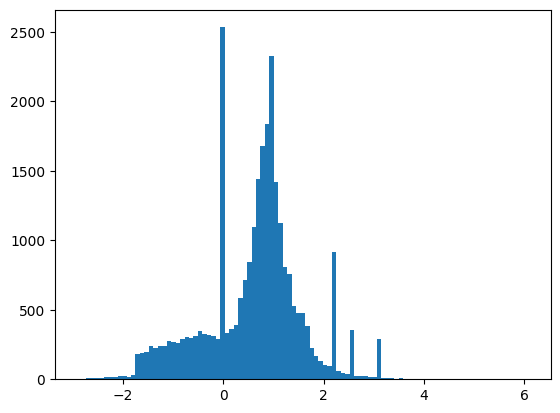

In [11]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)

In [12]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE=int(1e4)
BATCH_SIZE=500
STEPS_PER_EPOCHS = N_TRAIN/BATCH_SIZE

In [13]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [14]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [15]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [16]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCHS*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

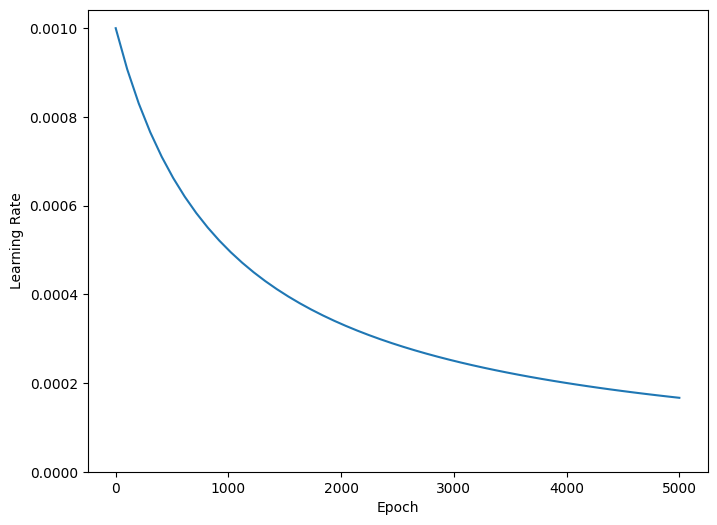

In [17]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCHS,lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [18]:
def get_callbacks(name):
  return [
      tfdocs.modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy',patience=200),
      tf.keras.callbacks.TensorBoard(logdir/name)
  ]

In [19]:
def compile_and_fit(model,name,optimizer=None,max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = [
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits=True, name='binary_crossentropy'
                    ),'accuracy'
                ]
                )
  model.summary()
  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCHS,
      epochs = max_epochs,
      validation_data = validate_ds,
      callbacks=get_callbacks(name),
      verbose=0
  )
  return history

ANALIZA MODELI

In [20]:
#model bardzo mały (tiny)

tiny_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [21]:
size_histories = {}

In [22]:
size_histories['Tiny'] = compile_and_fit(tiny_model,'size/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4854,  binary_crossentropy:0.7988,  loss:0.7988,  val_accuracy:0.4920,  val_binary_crossentropy:0.7272,  val_loss:0.7272,  
....................................................................................................
Epoch: 100, accuracy:0.5888,  binary_crossentropy:0.6288,  loss:0.6288,  val_accuracy:0.5790,  val_binary_crossentropy:0.6291,  val_loss:0.6291,  
............................

(0.5, 0.7)

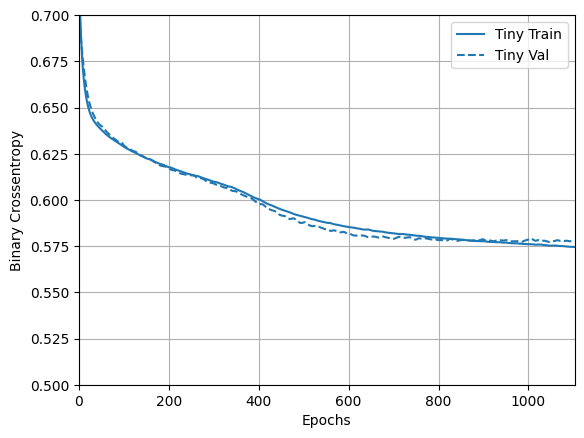

In [23]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy',smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

In [24]:
#mały model (small)

small_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(16,activation='elu'),
    layers.Dense(1)
])

In [25]:
size_histories['Small'] = compile_and_fit(small_model,'size/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4788,  binary_crossentropy:0.7428,  loss:0.7428,  val_accuracy:0.4840,  val_binary_crossentropy:0.7100,  val_loss:0.7100,  
....................................................................................................
Epoch: 100, accuracy:0.6318,  binary_cros

(0.5, 0.7)

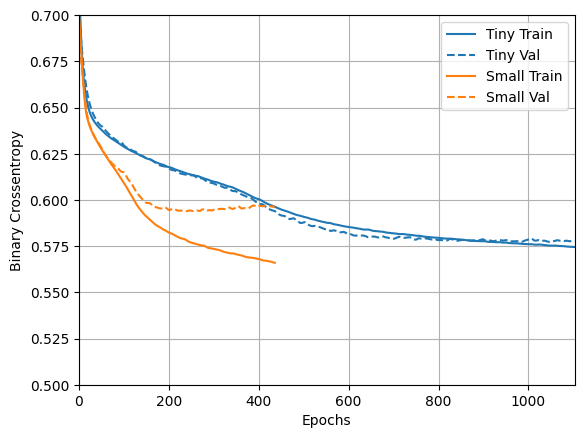

In [26]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy',smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

In [27]:
#model średni (medium)
medium_model = tf.keras.Sequential([
    layers.Dense(64,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(64,activation='elu'),
    layers.Dense(64,activation='elu'),
    layers.Dense(1)
])

In [28]:
size_histories['Medium'] = compile_and_fit(medium_model,'size/Medium')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10241 (40.00 KB)
Trainable params: 10241 (40.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4940,  binary_crossentropy:0.6934,  loss:0.6934,  val_accuracy:0.4950,  val_binary_crossentropy:0.6773,  val_loss:0.6773,  
....

(0.5, 0.7)

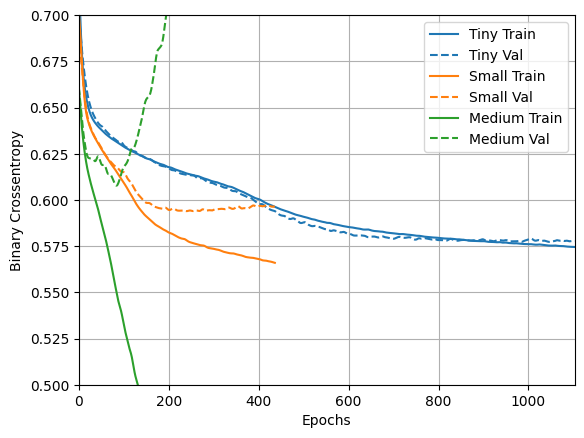

In [29]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy',smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

In [30]:
#duży model(large)
large_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(1)
])

In [31]:
size_histories['Large'] = compile_and_fit(medium_model,'size/Large')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10241 (40.00 KB)
Trainable params: 10241 (40.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.8146,  binary_crossentropy:0.3787,  loss:0.3787,  val_accuracy:0.6410,  val_binary_crossentropy:0.7954,  val_loss:0.7954,  
....

Text(0.5, 0, 'Epochs [Log Scale]')

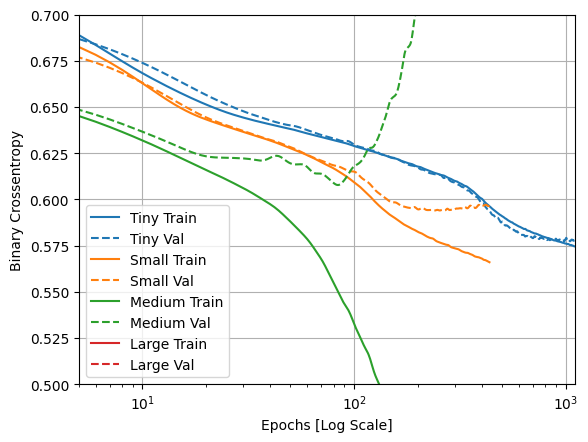

In [32]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5,max(plt.xlim())])
plt.ylim([0.5,0.7])
plt.xlabel('Epochs [Log Scale]')

In [34]:
# STRATEGIE ZAPOBIEGANIA NADMIERNEMU DOPASOWANIU (PRZETRENOWANIE)

shutil.rmtree(logdir/'regularizers/Tiny',ignore_errors=True)
shutil.copytree(logdir/'size/Tiny',logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpd4zv2klt/tensorboard_logs/regularizers/Tiny')

In [35]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

REGULARYZACJA WAG

In [36]:
#duży model(large l2)
l2_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001),input_shape=(FEATURES,)),
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model,'regularizers/l2')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

(0.5, 0.7)

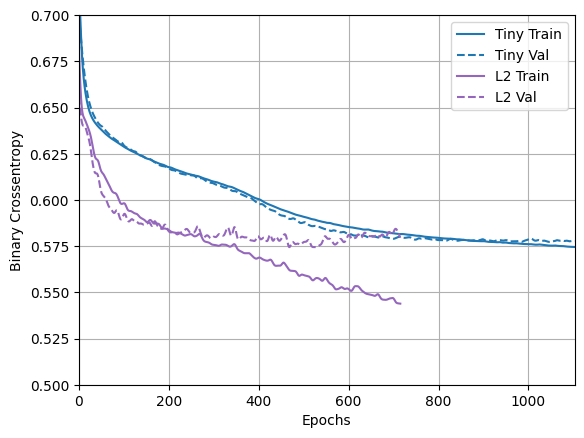

In [37]:
plotter.plot(regularizer_histories)
plt.ylim([0.5,0.7])

In [38]:
#duży model(large l2 + droput)
combined_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001),input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(l2_model,'regularizers/combined')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

(0.5, 0.7)

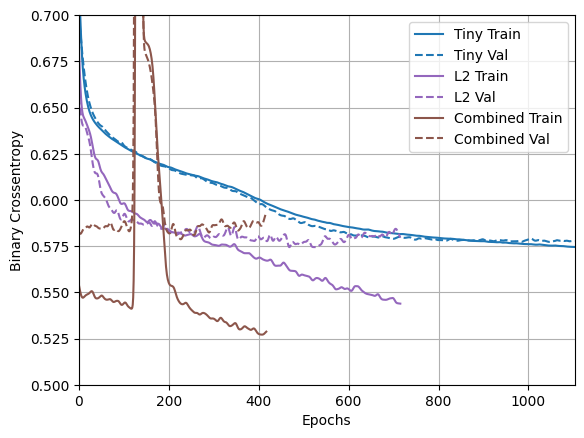

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5,0.7])